In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
from sklearn.model_selection import train_test_split
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

import re
from typing import List, Dict
    
from src.preprocessing.sequence_classification.dataset import get_n_shots_per_class
from src.preprocessing.sequence_classification.set_fit_dataset import SetFitDataset
from src.model.sequence_classification.trainer import SequenceClassificationTrainer
import warnings
warnings.filterwarnings("ignore")

In [3]:
!mkdir logs
model_name = "SetFit"
dataset_name = "AG_news"
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
# logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)

mkdir: cannot create directory ‘logs’: File exists


## SetFit

In [4]:
model = SentenceTransformer("whaleloops/phrase-bert")

In [5]:
try:
    from torch.hub import _get_torch_home

    torch_cache_home = _get_torch_home()
except ImportError:
    torch_cache_home = os.path.expanduser(os.getenv('TORCH_HOME', os.path.join(os.getenv('XDG_CACHE_HOME', '~/.cache'), 'torch')))

cache_folder = os.path.join(torch_cache_home, 'sentence_transformers')

In [6]:
cache_folder

'/users/eleves-a/2022/pedro.silva/.cache/torch/sentence_transformers'

In [7]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': None}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

## Loading AGnews data

In [8]:
ag_news_dataset = load_dataset("ag_news")

In [9]:
num_classes = len(ag_news_dataset['train']\
    .features['label']\
    .names)

classes_names = ag_news_dataset['train']\
    .features['label']\
    .names

num_classes

4

In [10]:
data_size = len(ag_news_dataset['train'])
data_size

120000

In [11]:
train_text = ag_news_dataset['train']['text'][0:data_size*3//5]
train_labels = ag_news_dataset['train']['label'][0:data_size*3//5]

val_text = ag_news_dataset['train']['text'][data_size*3//5:]
val_labels = ag_news_dataset['train']['label'][data_size*3//5:]

In [14]:
X_train, y_train = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= 3,
    num_classes= num_classes
)

In [15]:
X_val, y_val = get_n_shots_per_class(
    val_text, 
    val_labels,
    n_shots = 6,
    num_classes=num_classes
)

In [16]:
set_fit_data_train = SetFitDataset(
    X_train,
    y_train, 
    input_example_format= True
    # R = 5
)

set_fit_data_val = SetFitDataset(
    X_val,
    y_val,
    # R = 5,
    input_example_format= False
)

In [17]:
train_dataloader = DataLoader(
    set_fit_data_train.data,
    shuffle=True
)

val_dataloader = DataLoader(
    set_fit_data_val
)

## Train embedding

In [21]:
model = SentenceTransformer("whaleloops/phrase-bert")
loss_fn = losses.CosineSimilarityLoss(model)
cos_sim = torch.nn.CosineSimilarity(dim = 1)

n_epochs = 10
best_f1 = 0
best_model = None

for epoch in range(n_epochs):
    model.fit(
        train_objectives=[ (train_dataloader, loss_fn)],
        epochs = 1,
        show_progress_bar=False
    )

    y_true_val = torch.tensor([],device=device)
    y_pred_val = torch.tensor([],device=device)

    print(f"Running validation after {epoch} epochs")

    for [x1, x2, y] in tqdm(val_dataloader):
        with torch.no_grad():
            v1 = model.encode(x1, convert_to_tensor= True)
            v2 = model.encode(x2, convert_to_tensor= True)

            cos = cos_sim(v1, v2)

            y_pred = round(cos.item())
            y_true = y

            y_pred_val = torch.cat([
                y_pred_val, 
                torch.tensor([y_pred]).to(device)
            ])

            y_true_val = torch.cat([
                y_true_val, 
                torch.tensor([y_true]).to(device)
            ])
            
    f1 = binary_f1_score(
        y_pred_val,
        y_true_val,
    )
    if f1 > best_f1:
        best_f1 = f1
        best_model = deepcopy(model)

    conf_matrix= multiclass_confusion_matrix(
        y_pred_val.to(torch.int64),
        y_true_val.to(torch.int64),
        num_classes=2
    )

    print(f'f1 score: {f1.item()}')
    print(conf_matrix)

Running validation after 0 epochs


100%|██████████| 276/276 [00:02<00:00, 135.91it/s]


f1 score: 0.8115941882133484


KeyboardInterrupt: 

## Training classifier 

In [37]:
class CLF(torch.nn.Module):
    def __init__(
        self,
        in_features : int,
        out_features : int, 
        *args, 
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.layer1 = torch.nn.Linear(in_features, 512)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(512, 256)
        self.layer3 = torch.nn.Linear(256, out_features)

    def forward(self, x : torch.Tensor):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        return self.layer3(x)
    

In [ ]:
X

In [52]:
X_train, y_train = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= 3,
    num_classes= num_classes
)
X_val, y_val = get_n_shots_per_class(
    val_text, 
    val_labels,
    n_shots = 100,
    num_classes=num_classes
)

In [35]:
from random import shuffle
def shuffle_two_lists(X, y ):
    X_shuff = []
    y_shuff = []
    index_shuf = list(range(len(X)))
    shuffle(index_shuf)
    for i in index_shuf:
        X_shuff.append(X[i])
        y_shuff.append(y[i])


    return X_shuff, y_shuff

In [30]:
X_train_shuffled , y_train_shuffled = shuffle_two_lists(X_train, y_train)

In [55]:
from IPython.display import clear_output

In [71]:
embedding_model = SentenceTransformer("peulsilva/phrase-bert-setfit-3shots")\
    .to(device)

in_features = embedding_model.get_sentence_embedding_dimension()
clf = CLF(
    in_features,
    num_classes,
).to(device)


loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    clf.parameters(),
    lr = 1e-5
)

best_model = None
best_f1 = 0
n_epochs = 100

history = []

for epoch in (range(n_epochs)):
    for i in tqdm(range(len(X_train))):
        text = X_train_shuffled[i]
        label = torch.tensor(y_train_shuffled[i])\
            .to(device)

        with torch.no_grad():
            embedding = embedding_model.encode(text, convert_to_tensor=True)

        optimizer.zero_grad()
        output = clf(embedding)
        loss = loss_fn(output, label)


        loss.backward()
        optimizer.step()

    y_true_val = torch.tensor([],device=device)
    y_pred_val = torch.tensor([],device=device)

    for i in range(len(X_val)):
        text = X_val[i]
        label = torch.tensor(y_val[i])\
            .to(device)

        with torch.no_grad():
            embedding = embedding_model.encode(text, convert_to_tensor=True)

            y_pred = clf(embedding)\
                .argmax()
            
            y_pred_val = torch.cat([
                y_pred_val, 
                torch.tensor([y_pred]).to(device)
            ])

            y_true_val = torch.cat([
                y_true_val, 
                torch.tensor([y_val[i]]).to(device)
            ])
            
    f1 = multiclass_f1_score(
        y_pred_val,
        y_true_val,
        num_classes=num_classes
    )
    
    history.append(f1.item())
    if f1 > best_f1:
        best_f1 = f1
        best_model = deepcopy(clf)

    conf_matrix= multiclass_confusion_matrix(
        y_pred_val.to(torch.int64),
        y_true_val.to(torch.int64),
        num_classes=num_classes
    )

    clear_output()
    print(f"---------Epoch: {epoch}-----------")
    print(f'f1 score: {f1.item()}')
    print(conf_matrix)

---------Epoch: 99-----------
f1 score: 0.7900000214576721
tensor([[90,  1,  7,  2],
        [14, 83,  0,  3],
        [13,  0, 69, 18],
        [ 6,  1, 19, 74]], device='cuda:0')


In [73]:
best_epoch = 0
for idx, f1 in enumerate(history):
    if f1 == best_f1.item():
        best_epoch = idx

In [74]:
best_epoch

79

Text(0.5, 1.0, 'SetFit training results- AG news - 3 shots')

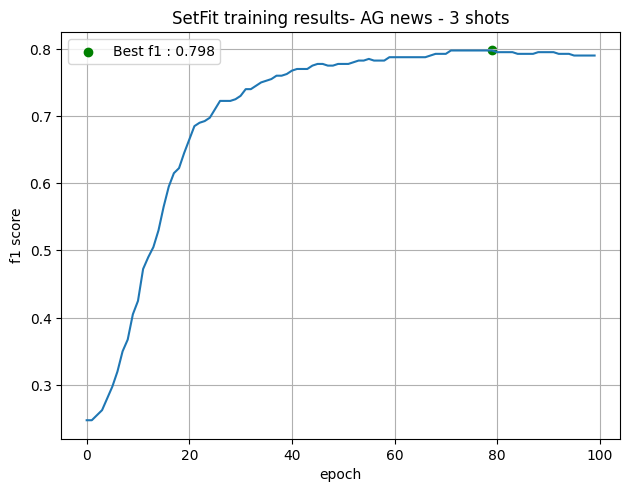

In [85]:
# history = ([k.to('cpu').numpy() for k in history])
plt.plot(history)
plt.scatter(
    [best_epoch], 
    best_f1.item(),
    color = "green",
    label = f"Best f1 : {round(best_f1.item(),3)}"
)
plt.grid()
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.tight_layout()
plt.title("SetFit training results- AG news - 3 shots")